In [192]:
%load_ext autoreload
%autoreload

import json
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import tqdm
import random
import torch
import sklearn
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
import inlp, inlp_dataset_handler, inlp_linear_model
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
with open('tweets.above-120.jsonl', "r", encoding = "utf-8") as f:
  lines = f.readlines()

all_tweets = []

for line in tqdm_notebook(lines[:]):
    d = json.loads(line)
    text = d["text"]
    lang = d["lang"]
    if lang is not None and "http" not in text and "@" not in text:
        
        all_tweets.append({"text": text.replace("\n", ".").lower(), "lang": lang})

/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [188]:
data = []
n = 100

langs = ["en", "iw", "es", "pt", "it", "fr", "in", "hi", "de", "ru", "nl", "ja", "th", "tl"]

for lang in langs:    
    lang_tweets = [d for d in all_tweets if d["lang"] == lang]
    print(lang, len(lang_tweets))
    for i in range(n):
        tweet = random.choice(lang_tweets)
        data.append({"lang": lang, "text": tweet["text"]})

en 44735
iw 150
es 11434
pt 16348
it 730
fr 2235
in 5788
hi 2703
de 489
ru 1128
nl 340
ja 2128
th 1138
tl 2495


In [189]:
from collections import Counter
langs = [d["lang"] for d in all_tweets]
counter = Counter(langs)
print(counter.most_common(100))

[('en', 44735), ('pt', 16348), ('es', 11434), ('ar', 6116), ('in', 5788), ('tr', 3822), ('hi', 2703), ('tl', 2495), ('fr', 2235), ('ja', 2128), ('th', 1138), ('ru', 1128), ('it', 730), ('und', 683), ('de', 489), ('ur', 482), ('ht', 467), ('fa', 366), ('nl', 340), ('cy', 238), ('ko', 200), ('pl', 188), ('ca', 164), ('fi', 154), ('iw', 150), ('sv', 138), ('et', 89), ('ne', 75), ('da', 73), ('el', 68), ('mr', 68), ('ta', 65), ('cs', 65), ('uk', 64), ('zh', 51), ('bn', 39), ('ro', 35), ('ml', 35), ('hu', 27), ('lv', 27), ('sl', 27), ('no', 25), ('sr', 23), ('te', 22), ('kn', 21), ('vi', 15), ('si', 12), ('or', 11), ('ps', 10), ('is', 9), ('bg', 8), ('lt', 8), ('ckb', 8), ('eu', 6), ('gu', 4), ('sd', 3), ('pa', 3), ('my', 2), ('dv', 2), ('am', 2)]


## Run BERT

In [190]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-base-multilingual-uncased", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-uncased', config = config)

        #config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
        
        #config = AlbertConfig.from_pretrained("albert-xlarge-v2", output_hidden_states=True)
        #self.tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
        #self.model = AlbertModel.from_pretrained("albert-xlarge-v2", config = config)
        #config = RobertaConfig.from_pretrained("roberta-large", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        #self.model = RobertaModel.from_pretrained('roberta-large', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str], capitalize = False) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        if capitalize:
            
            w = list(original_sentence[0])
            w[0] = w[0].upper()
            
            original_sentence[0] = "".join(w)
            
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        
        
        
def collect_bert_states(bert, data: List[Tuple], layers: List[int], strategy = "mean"):
    
        for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):

            text = d["text"]
            sent = " ".join(text)
            preds, orig2tok = bert.encode(sent, layers = layers)
        
            if strategy == "sum":
                states = np.sum(preds, axis = 0)
            elif strategy == "cls":
                states = preds[0]
            elif strategy == "rand-word":
                states = preds[random.choice(range(len(preds)))]
            data[i]["vec"] = states
    
        return data

In [105]:
bert = BertEncoder(device = "cpu")

In [191]:
data_with_states = collect_bert_states(bert, copy.deepcopy(data), layers = [1], strategy = "cls")

NameError: name 'copy' is not defined

## TSNE by language

In [113]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "black", "grey", "red", "purple", "pink", "brown", "cyan", "magenta", "gold", "brown"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        plt.scatter(vecs_2d[labels == label, 0], vecs_2d[labels == label, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
  plt.legend()
  

  plt.title(title)

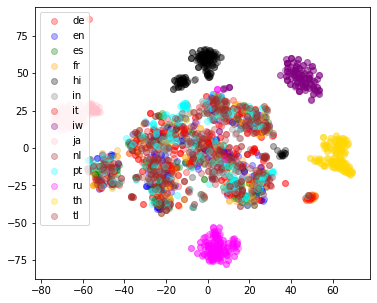

In [186]:
random.shuffle(data_with_states)
vecs = np.array([d["vec"] for d in data_with_states][:])
labels_lang = np.array([d["lang"] for d in data_with_states][:])
tsne(vecs, labels_lang)

## Classify language

In [208]:
l = int(len(vecs) * 0.9)
x_train_cls, x_dev_cls = vecs[:l], vecs[l:]
y_train_cls, y_dev_cls = labels_lang[:l], labels_lang[l:]
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(x_train_cls, y_train_cls)
print(model.score(x_dev_cls, y_dev_cls))

0.5464285714285714


## Create dataset for INLP

In [172]:
num_examples_per_language = 100
vecs1, vecs2, labels = [], [], []
for lang in langs:
    
    relevant = [d for d in data_with_states if d["lang"] == lang]
    rest = [d for d in data_with_states if d["lang"] != lang]
    for i in range(num_examples_per_language):
        positive_pair = random.choice(relevant)["vec"], random.choice(relevant)["vec"]
        negative_pair = random.choice(relevant)["vec"], random.choice(rest)["vec"]
        
        # positive
        
        vecs1.append(positive_pair[0])
        vecs2.append(positive_pair[1])
        labels.append(1)
        
        # negative 
        vecs1.append(negative_pair[0])
        vecs2.append(negative_pair[1])
        labels.append(0)

vecs1, vecs2, labels = sklearn.utils.shuffle(vecs1, vecs2, labels)
vecs1 = np.array(vecs1)
vecs2 = np.array(vecs2)
labels = np.array(labels)

l = int(len(vecs) * 0.9)
x_train1, x_dev1 = vecs1[:l], vecs1[l:]
x_train2, x_dev2 = vecs2[:l], vecs2[l:]
y_train, y_dev = labels[:l], labels[l:]

concat_train = np.concatenate([x_train1, x_train2], axis = 1)
concat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(concat_train, y_train)
print(model.score(concat_dev, y_dev))

0.5214285714285715


## INLP data preparation

In [193]:
inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 25, "input_dim": 768, "hidden_dim": 32, "batch_size": 64, "verbose": False, "device": "cpu",
         "compare_by": "dot_product", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = False)

In [194]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 10, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)


  0%|          | 0/10 [00:00<?, ?it/s]INFO:root:
         Name               Type Params
0          l1             Linear   24 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:314: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)
/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:144: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,val_acc,avg_val_loss
  RuntimeWarning)

iteration: 0, accuracy: 0.6458333730697632:  10%|█         | 1/10 [00:00<00:04,  2.05it/s]INFO:root:
         Name               Type Params
0          l1             Linear   24 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
/home/shauli/anaconda3/envs/py3/lib/python3.7/s

iteration: 9, accuracy: 0.5239583253860474: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


In [206]:
v_rowspace = []
for w in Ws:
        
    w_norm = w/np.linalg.norm(w)
    v_rowspace.append(w_norm.dot(vecs.T))
    
v_rowspace = np.array(v_rowspace)
print(v_rowspace.shape)

(10, 1, 2800)


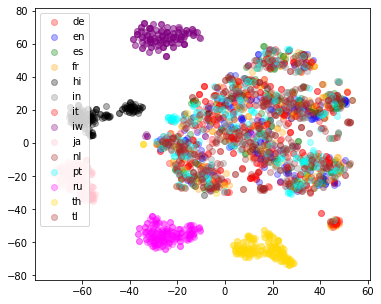

In [195]:
P_rowspace = np.eye(P.shape[0]) - P
tsne(P_rowspace.dot(vecs.T).T, labels_lang)

## Classification INLP

In [202]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train_cls, y_train_cls, x_dev_cls, y_dev_cls, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 5000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"max_iter": 10000, "alpha": 0.1, "n_iter_no_change": 10})

In [203]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 10, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)


iteration: 9, accuracy: 0.4785714285714286: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


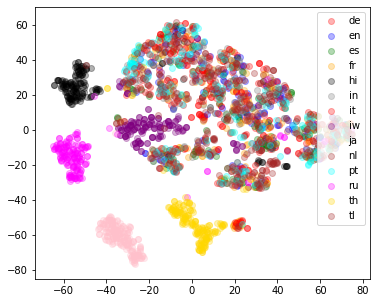

In [209]:
P_rowspace = np.eye(P.shape[0]) - P
tsne(P_rowspace.dot(x_train_cls.T).T, y_train_cls)